In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Classic AB-Test

На данный момент конверсия покупок на сайте составляет 40%, то есть 40 из 100 юзеров, которые добавили товар в корзину завершают офрмление заказа. Заказы же остальных юзеров продолжают лежать в корзине. Было решено побуждать юзеров закончить оформление покупки путем рассылки пуш-ап. 

Нужно проверить, увеличилась ли конверсия? Ожидаемый результат увеличение конверсии с 40% до 42%.

Необходимо рассчитать, какое количество наблюдений должно быть проведено, чтобы мы увидели абсолютное изменение конверсии на 2% (или относительное на 5%), <b>с уровнем значимости 95%</b> (т.е. alpha - 0.05, вероятность заметить изменения, если выборки не различаются, т.е. ошибочно отвергнуть нулевую гипотезу о равенстве выборок (<i>вероятность ошибки первого рода составляет 5%</i>)), <b>и мощность - 80%</b> (т.е. вероятность правильного принятия альтернативной гипотезы о неравенстве выборок в предположении, что оно верное (<i>вероятность ошибки второго рода, не заметить резлуьтат, когда он есть, составляет 20%</i>))

In [2]:
# текущая конверсия
baseline_rate = 0.4

# minimum detectable effect по факту составляет[38-42]
# но наш результат оказался лучше, увеличив конверсию до 45%
# в жизни мы никогда не узнаем этого значения точно
result_rate = 0.42

#размер выборки
sample_size = 9_440

alpha = 0.05

In [3]:
# проводим тестирование 
np.random.seed(513)
control = np.random.binomial(n=1, p=baseline_rate, size=sample_size)
treatment = np.random.binomial(n=1, p=result_rate, size=sample_size)

## Выбор статистического критерия

У нас номинальные выборки (0/1) в количестве двух независимых групп с достаточно большим количеством наблюдений. Поэтому остановимся на тесте Хи-Квадрат.

$H_0$: разницы между выборками нет, т.е. влияние пуш-апов не статистически значимо  
$H_1$: между выборками есть статистички важная разница

In [4]:
have_bought = [sum(control==1), sum(treatment==1)] # совершена покупка
have_not_bought = [sum(control==0), sum(treatment==0)] # покупка не завершена

# считаем тест
_, pvalue, *_ = stats.chi2_contingency([have_bought, have_not_bought])

In [5]:
if pvalue < alpha:
    print('У нас есть основания утверждать, что между выборками есть статистичски важная разница')
    print(f'Вероятность получить подобные распределения, если между выборками нет разницы - {pvalue:.2%}')
    print('Нулевая гипотеза может быть отвергнута')
else:
    print('У нас есть основания утверждать, что между выборками отсутствует статистичски важная разница')
    print(f'Вероятность получить подобные распределения, если между выборками нет разницы - {pvalue:.2%}')
    print('Нулевая гипотеза не может быть отвергнута')
    
print('-'*100)
print('-'*100)


# проверка, в какую сторону произошли изменения, т.к. тест был двусторонний
# показатели могли измениться в худшую сторону, например, кто-то бы посчитал это навязчивым 
# и перестал бы совершать покупки в данном магазине

if control.sum() < treatment.sum():
    print('Выборка после внедрения пуш-ап сообщений превосходит контрольную группу')
else:
    print('Выборка после изменений либо не превосходит контрольную группу, либо ухудшила показатели')

У нас есть основания утверждать, что между выборками есть статистичски важная разница
Вероятность получить подобные распределения, если между выборками нет разницы - 1.40%
Нулевая гипотеза может быть отвергнута
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Выборка после внедрения пуш-ап сообщений превосходит контрольную группу


Результаты после AB теста стали лучше. Но насколько? Как было указано выше, мы не знаем, что конверсия стала 45%. Мы просто знаем, что между контролем и тритментом есть положительная разница на 2%, и этот результат статистически значимый. 

Чтобы узнать, нсколько одна лучше другой, воспользуемся AB Bayes тестом

#  BAYES AB-Test

Так как мы будет пользоваться $Beta$-распределением, нам нужно узнать число успехов и неуспехов при проведении эксперимента. Успех - совершение покупки, неуспех - юзер покинул корзину, не завершив покупку.

In [6]:
# контрольная группа
control_buy = control.sum()
control_dont_buy = sum(control==0)

# тест-группа
treatment_buy = treatment.sum()
treatment_dont_buy = sum(treatment==0)

# априорные представления. Допустим, мы не верим, что будут какие-то результаты
# тогда альфа и бета будут единицами, что тождествено uniform-распределению
alpha = 1
beta = 1

In [7]:
# наши полученные апостериорные распределения
posterior_control = stats.beta(control_buy+alpha, control_dont_buy+beta)
posterior_treatment = stats.beta(treatment_buy+alpha, treatment_dont_buy+beta)

In [8]:
# генерируем выборки из наших распределений по 1000 штук
control_samples = posterior_control.rvs(1000)
treatment_samples = posterior_treatment.rvs(1000)

#сравнение результатов
result = np.mean(treatment_samples > control_samples)

print(f'Вероятность того, что после введения пуш-ап сообщений результаты улучшились составляет {result:.2%}')
print(f'Вероятность того, что после введения пуш-ап сообщений результаты ухудшились составляет {1-result:.2%}')

Вероятность того, что после введения пуш-ап сообщений результаты улучшились составляет 99.50%
Вероятность того, что после введения пуш-ап сообщений результаты ухудшились составляет 0.50%


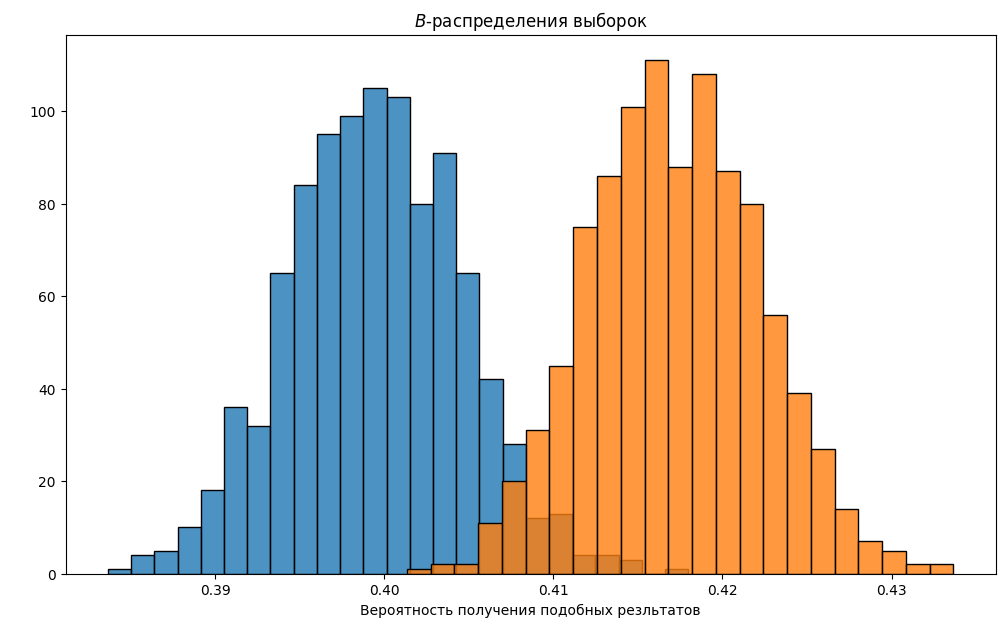

In [9]:
plt.figure(figsize=(12,7))
sns.histplot(control_samples, alpha=0.8, label='Контрольная группа')
sns.histplot(treatment_samples, alpha=0.8, label='Тестовая группа')
plt.title('$B$-распределения выборок')
plt.xlabel('Вероятность получения подобных резльтатов')
plt.ylabel(' ')
plt.show()

Теперь мы можем утверждать, что после внедрений пуш-ап сообщений результаты стали не просто статистичски значимы, а улучшились: конверсия в 42% вместо 40% будет наблюдаться в 99% случаев.

Один их плюсов такого подхода, можно наблюдать результаты в ходе эксперимента, т.к. тут нет p-хакинга, подсматривания и оценки стат значимости при недостаточном числе наблюдений. Также этот подход более интерпритируемый.

Также одним из методов тестирование является метод многоруких бандитов, который можно применять для тестирования A/B/C/D и т.д. групп, при небольшом трафике на сайте, можно следить за процессом и быстрее получить результаты

# Multi Armed Bandit (MAB)

Алгоритмы, широко применяемые при обучении роботов и алгоритмов(Reinforcement learning), когда неодушевленный объект получает награду за желаемое действие и штрафуется за неверное действие. Подобные алгоритмы также применяются в статистических тестированиях. 

## UCB

Здесь будет применяться один из методов многоруких бандитов - Upper Confidence Bound (UCB), который также называют "оптимизм в лице неопределенности".

Опеределяет лучший алгоритм следующая формула: 
<center>$\sigma= \bar{x} + \beta * \sqrt{(2*ln(n)\over n_i}$ где,</center> 

$\bar{x}$ - среднее число побед данного автомата;  
$\beta$ - корректирующий коэффициент, по умолчанию равен 0.99;  
$\ln(n)$ - натуральный логарим суммы всех текущих попыток;  
$n_i$ - число попыток для данного автомата


Алгоритм заключается в следующем: каждая группа в нашем тесте - игровой автомат с рычагом. В самом начале мы дергаем рычаг каждого автомата, чтобы определить, какой автомат с наибольшей вероятностью даст нам выигрыш. Даже в случае неудач каждого автомата, сигма продолжает расти. Определив лучший автомат, мы начинаем отдавать предпочтение ему, чаще дергая его ручку. Это продолжается, пока череда неудач не заставит нас переключиться на другой автомат. 

In [10]:
# сколько раз "дергаем рычаг". т.е. выбираем группу
steps = 3000
# число групп
groups = 2

# сколько раз мы выбрали группу 0 и 1 группы
# сразу задаем, что выбрали по 1 разу
numbers_of_selection = [1] * groups
# вознагржадение группы 0 и 1
sum_of_rewards = [0] * groups

# для отрисовки графика
success = {0:[], 1:[]}

In [11]:
def sigma_calc(avg, ni, n, beta=0.99):
    
    """
    avg - среднее число вознаграждений
    ni - сколько раз дергали рычаг этого бандита, т.е. сколько раз к нему обращались
    n - номер общей текущей попытки (т.е. сколько раз в сумме мы дернули за рычаг каждый автомат)
    """
    return avg + beta * np.sqrt((2 * np.log(n) / ni))

In [12]:
for step in range(steps):
    
    # список с поулченными сигмами
    # наибошьшее значение отражает наибольшую вероятность "выигрыша" этой группы
    sigmas = []
    for group in range(groups):
        # рассчет среднего числа вознаграждений в текущей группе group
        avg = sum_of_rewards[group] / numbers_of_selection[group]
        
        # рассчет самой сигмы этой группы
        sigma = sigma_calc(avg=avg,
                           ni=numbers_of_selection[group],
                           n = step + 1)
        sigmas.append(sigma)

    # выбираем группу с наибольшей сигмой
    ad = np.argmax(sigmas)
    
    # для выбранной группы увеличиваем счетчик на единицу 
    numbers_of_selection[ad] = numbers_of_selection[ad] + 1
    # дергаем за рычаг и ждем 0 или 1
    reward = np.random.choice([control, treatment][ad])
    # считаем общее число побед
    sum_of_rewards[ad] = sum_of_rewards[ad] + reward
    
    success.get(0).append(sum_of_rewards[0])
    success.get(1).append(sum_of_rewards[1])
    
    
    if (step + 1) % 1000 == 0:
        
        print(f'Число удач контрольной группы {sum_of_rewards[0]}')
        print(f'Число удач тестовой группы {sum_of_rewards[1]}')

Число удач контрольной группы 193
Число удач тестовой группы 203
Число удач контрольной группы 487
Число удач тестовой группы 323
Число удач контрольной группы 564
Число удач тестовой группы 687


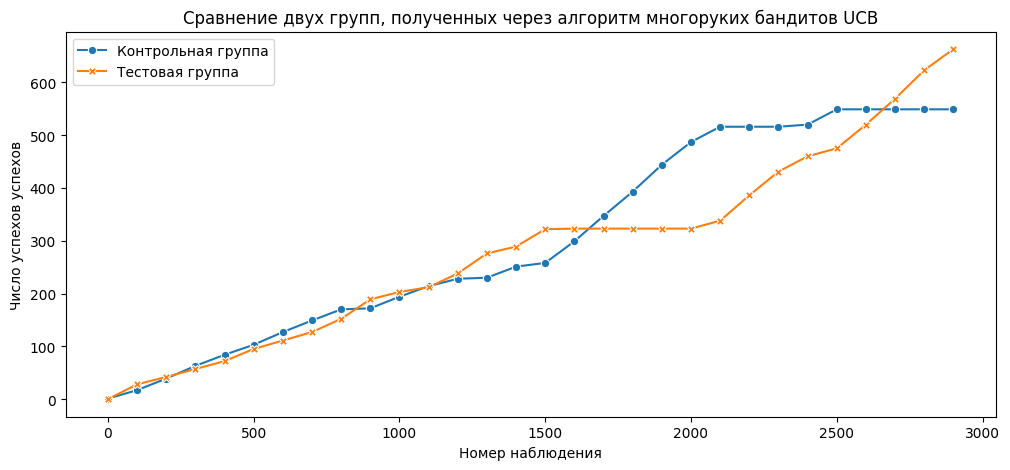

In [13]:
# возьмем каждое сотое наблюдение
x_axis = np.arange(0, steps, 100)
control_list = np.array(success[0])[x_axis]
treatment_list = np.array(success[1])[x_axis]

plt.figure(figsize=(12,5))
sns.lineplot(x=x_axis, y=control_list, label='Контрольная группа', marker='o')
sns.lineplot(x=x_axis, y=treatment_list, label='Тестовая группа', marker='X')
plt.title('Сравнение двух групп, полученных через алгоритм многоруких бандитов UCB')
plt.xlabel('Номер наблюдения')
plt.ylabel('Число успехов успехов')
plt.show()

In [14]:
control_ucb = sum_of_rewards[0]  / sum(sum_of_rewards)
treat_ucb = sum_of_rewards[1] / sum(sum_of_rewards)

print(f'Число побед контрольной группы от общего числа побед составляет {control_ucb:.2%}')
print(f'Число побед тестовой группы от общего числа побед составляет {treat_ucb:.2%}')

Число побед контрольной группы от общего числа побед составляет 45.08%
Число побед тестовой группы от общего числа побед составляет 54.92%


## E-Greedy

Данный лагоритм проще UCB, но склонен к излишнему вниманию к наиболее успешному автомату, игнорируя другие. Например, он можем "мучить" автомат, где вероятность победы 0.4, из-за того, что в автомате с вероятностью 0.7 ему 4 раза неповезло (0.3^4).

E - это Epsilon, то есть некое число в интервале от 0 до 1. По этой границе мы определяем наши дальнейшие действия:
- если случайное число меньше E, то мы выбираем самый "успешный" автомат, т.е. тот, где больше число выигрышей
- если случайное число больше E, то мы случайным образом выбираем один из автоматов. Это позволит алгоритму переключать свое внимание между автоматами

In [15]:
# полностью дублируем исходные данные
steps = 3000
groups = 2

numbers_of_selection_greedy = [1] * groups
sum_of_rewards_greedy = [0] * groups

# добавляем epsilon, нашу границу приянтия решений

# для отрисовки графика
success_1 = {0:[], 1:[]}

In [16]:
eps = 0.5
for i in range(steps):
    
    random = np.random.random()
    
    # если случайно число меньше эпсилон, 
    # то мы дергаем рычаг самого успешного автомата
    if random < eps:
        idx = np.argmax(sum_of_rewards)
    # иначе выбираем рандомный автомат
    else:
        idx = np.random.choice([0,1])

    # для выбранной группы увеличиваем счетчик на единицу 
    numbers_of_selection_greedy[idx] = numbers_of_selection_greedy[idx] + 1
    # дергаем за рычаг и ждем 0 или 1
    reward = np.random.choice([control, treatment][idx])
    # считаем общее число побед
    sum_of_rewards_greedy[idx] = sum_of_rewards_greedy[idx] + reward

    success_1.get(0).append(sum_of_rewards_greedy[0])
    success_1.get(1).append(sum_of_rewards_greedy[1])       

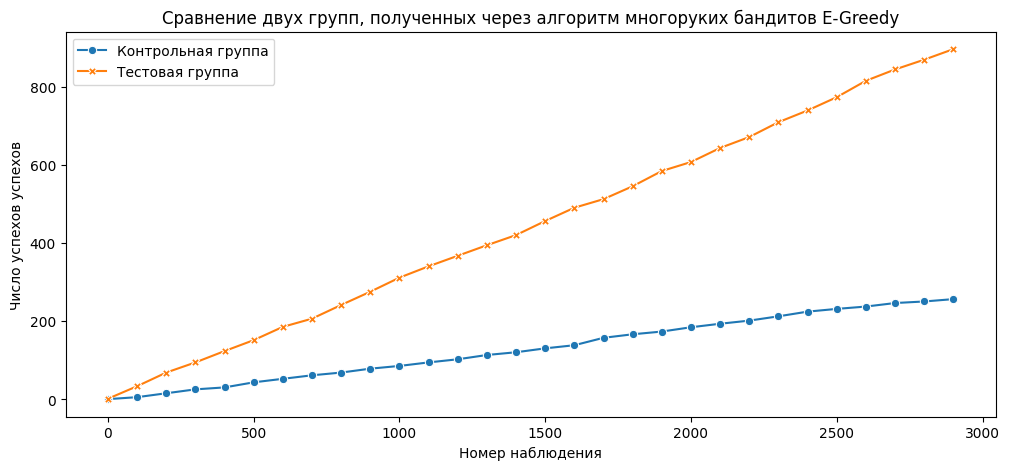

In [17]:
# возьмем каждое сотое наблюдение
x_axis = np.arange(0, steps, 100)
control_list_greedy = np.array(success_1[0])[x_axis]
treatment_list_greedy = np.array(success_1[1])[x_axis]

plt.figure(figsize=(12,5))
sns.lineplot(x=x_axis, y=control_list_greedy, label='Контрольная группа', marker='o')
sns.lineplot(x=x_axis, y=treatment_list_greedy, label='Тестовая группа', marker='X')
plt.title('Сравнение двух групп, полученных через алгоритм многоруких бандитов E-Greedy')
plt.xlabel('Номер наблюдения')
plt.ylabel('Число успехов успехов')
plt.show()

In [18]:
control_greedy = sum_of_rewards_greedy[0]  / sum(sum_of_rewards_greedy)
treat_greedy = sum_of_rewards_greedy[1] / sum(sum_of_rewards_greedy)

print(f'Число побед контрольной группы от общего числа побед составляет {control_greedy:.2%}')
print(f'Число побед контрольной группы от общего числа побед составляет {treat_greedy:.2%}')

Число побед контрольной группы от общего числа побед составляет 22.42%
Число побед контрольной группы от общего числа побед составляет 77.58%


Насколько разные результаты получились при разных алгоритмах: жадный алгоритм сразу выбрал себе лидера, за которым чаще больше. В случае же UCB алгоритма победа тестовой группы есть, но разница с контрольной очень небольшая, что нормально для для выборок с такими близкими вероятностями: 0.4 и 0.42

# Завершение

Проведя серию экспериментов с АБ-тестом, мы установили:
- существование стат значимого различия между ними
- 99% превосходство одного выборки над другой, т.е. увеличение конверсии на 2% будет наблюдаться в 99% случаев
- сделали тестирование с помощью алгоритмов многоруких бандитов, также убедившись в превосходестве варианта с пуш-уведомлениями